# Objective:
Leverage Python and SQL to analyze the E-commerce dataset "Exploring-Ecommerce-database-and-Implementing-Data-Mining". Your task is to extract insights from the data, focusing on customer behavior, product performance, and sales trends.

# Simplified ERD Diagram

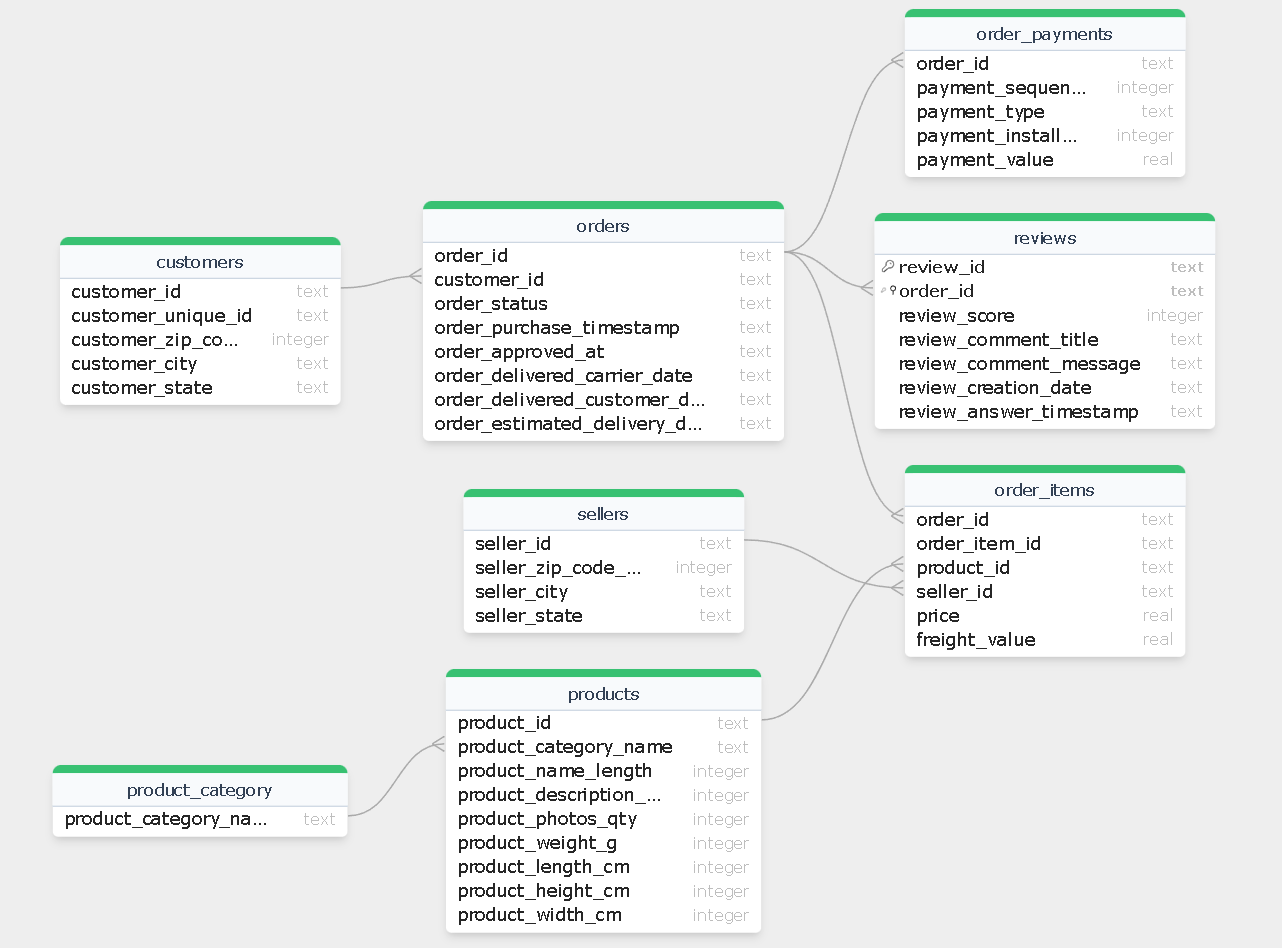

# Clone the dataset Github repo

In [ ]:
!git clone https://github.com/mudit-parmar/Exploring-Ecommerce-database-and-Implementing-Data-Mining

Cloning into 'Exploring-Ecommerce-database-and-Implementing-Data-Mining'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 2), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (17/17), 24.42 MiB | 5.68 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# Import necessary Libraries

In [ ]:
import csv
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create the tables and foreign keys

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('debi.db')

# Create a cursor object
cursor = conn.cursor()

# Dropping tables if they exist to avoid errors
cursor.execute("DROP TABLE IF EXISTS order_payments")
cursor.execute("DROP TABLE IF EXISTS order_items")
cursor.execute("DROP TABLE IF EXISTS reviews")
cursor.execute("DROP TABLE IF EXISTS orders")
cursor.execute("DROP TABLE IF EXISTS customers")
cursor.execute("DROP TABLE IF EXISTS products")
cursor.execute("DROP TABLE IF EXISTS sellers")
cursor.execute("DROP TABLE IF EXISTS product_category")

# Creating tables
cursor.execute("""
CREATE TABLE customers (
    customer_id TEXT NOT NULL PRIMARY KEY,
    customer_unique_id TEXT,
    customer_zip_code INTEGER,
    customer_city TEXT,
    customer_state TEXT
)
""")

cursor.execute("""
CREATE TABLE product_category (
    product_category_name TEXT NOT NULL PRIMARY KEY
)
""")

cursor.execute("""
CREATE TABLE products (
    product_id TEXT NOT NULL PRIMARY KEY,
    product_category_name TEXT,
    product_name_length INTEGER,
    product_description_length INTEGER,
    product_photos_qty INTEGER,
    product_weight_g INTEGER,
    product_length_cm INTEGER,
    product_height_cm INTEGER,
    product_width_cm INTEGER,
    FOREIGN KEY (product_category_name) REFERENCES product_category(product_category_name)
)
""")

cursor.execute("""
CREATE TABLE sellers (
    seller_id TEXT NOT NULL PRIMARY KEY,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT CHECK (LENGTH(seller_state) <=2)
)
""")

cursor.execute("""
CREATE TABLE orders (
    order_id TEXT PRIMARY KEY,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    CHECK (order_status IN ('delivered', 'shipped', 'processing')),
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id)
)
""")

cursor.execute("""
CREATE TABLE reviews (
    review_id TEXT NOT NULL,
    order_id TEXT NOT NULL,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    PRIMARY KEY (review_id, order_id),
    CHECK (review_score>0 AND review_score<=5),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
)
""")

cursor.execute("""
CREATE TABLE order_items (
    order_id TEXT NOT NULL,
    order_item_id TEXT,
    product_id TEXT,
    seller_id TEXT,
    price REAL CHECK(price >= 0),
    freight_value REAL CHECK(freight_value >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id),
    FOREIGN KEY (product_id) REFERENCES products(product_id),
    FOREIGN KEY (seller_id) REFERENCES sellers(seller_id)
)
""")

cursor.execute("""
CREATE TABLE order_payments (
    order_id TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL CHECK(payment_value >= 0),
    FOREIGN KEY (order_id) REFERENCES orders(order_id)
)
""")

# Committing the transactions
conn.commit()

# Closing the connection
conn.close()


# Fill the tables

In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('debi.db')
cursor = conn.cursor()

# Create a temporary combined table to hold CSV data if it doesn't exist
cursor.execute("DROP TABLE IF EXISTS combined")
cursor.execute('''
CREATE TABLE IF NOT EXISTS combined (
    product_id TEXT,
    seller_id TEXT,
    order_id TEXT,
    customer_id TEXT,
    order_status TEXT,
    order_purchase_timestamp TEXT,
    order_approved_at TEXT,
    order_delivered_carrier_date TEXT,
    order_delivered_customer_date TEXT,
    order_estimated_delivery_date TEXT,
    customer_unique_id TEXT,
    customer_zip_code INTEGER,
    customer_city TEXT,
    customer_state TEXT,
    review_id TEXT,
    review_score INTEGER,
    review_comment_title TEXT,
    review_comment_message TEXT,
    review_creation_date TEXT,
    review_answer_timestamp TEXT,
    payment_sequential INTEGER,
    payment_type TEXT,
    payment_installments INTEGER,
    payment_value REAL,
    order_item_id TEXT,
    price REAL,
    freight_value REAL,
    seller_zip_code_prefix INTEGER,
    seller_city TEXT,
    seller_state TEXT,
    product_category_name TEXT,
    product_name_length INTEGER,
    product_description_length INTEGER,
    product_photos_qty INTEGER,
    product_weight_g INTEGER,
    product_length_cm INTEGER,
    product_height_cm INTEGER,
    product_width_cm INTEGER
)''')

# Load data from CSV into the temporary table
with open('/content/Exploring-Ecommerce-database-and-Implementing-Data-Mining/Orders_merged.csv', 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  # Skip header row
    for row in csv_reader:
        cursor.execute('''
        INSERT INTO combined VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);
        ''', row)

# Insert data into structured tables
cursor.execute('INSERT INTO customers SELECT DISTINCT customer_id, customer_unique_id, customer_zip_code, customer_city, customer_state FROM combined WHERE customer_id IS NOT NULL')
cursor.execute('INSERT INTO product_category SELECT DISTINCT product_category_name FROM combined WHERE product_category_name IS NOT NULL')
cursor.execute('INSERT INTO products SELECT DISTINCT product_id, product_category_name, product_name_length, product_description_length, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm FROM combined WHERE product_id IS NOT NULL')
cursor.execute('INSERT INTO orders SELECT DISTINCT order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO sellers SELECT DISTINCT seller_id, seller_zip_code_prefix, seller_city, seller_state FROM combined WHERE seller_id IS NOT NULL')
cursor.execute('INSERT INTO order_payments SELECT DISTINCT order_id, payment_sequential, payment_type, payment_installments, payment_value FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO order_items SELECT DISTINCT order_id, order_item_id, product_id, seller_id, price, freight_value FROM combined WHERE order_id IS NOT NULL')
cursor.execute('INSERT INTO reviews SELECT DISTINCT review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp FROM combined WHERE review_id IS NOT NULL')

# Commit changes and close the connection
conn.commit()
conn.close()

# Test that the database was created succesfully

In [ ]:
def print_top_rows(table_name):
    # Connect to SQLite database
    conn = sqlite3.connect('debi.db')
    cursor = conn.cursor()
    # Create SQL query string
    query = f"SELECT * FROM {table_name} LIMIT 10"

    # Execute the query
    cursor.execute(query)

    # Fetch the top 10 rows
    rows = cursor.fetchall()

    # Print the rows
    print(f"Top 10 rows from {table_name}:")
    for row in rows:
        print(row)

    # Close the connection
    conn.close()

# Use the function to print the top 10 rows from three tables

print_top_rows('customers')
print("----")
print_top_rows('products')
print("----")
print_top_rows('orders')
print("----")
print_top_rows('product_category')
print("----")
print_top_rows('reviews')

Top 10 rows from customers:
('86c180c33f454b35e1596a99da3dddc4', 'cd929c5ecff5fc60e9d808d33702e434', 95890, 'teutonia', 'RS')
('68f2b37558e27791155db34bcded5ac0', 'cbbeff6b693e69511cf9d059f4b71036', 14403, 'franca', 'SP')
('6cd217b674e22cf568f6a2cf6060fd07', 'f51fb63558e88eb3373773d106fa6880', 2883, 'sao paulo', 'SP')
('8517e7c86998bf39a540087da6f115d9', '7f2dfd48dba158dbf61ba2ea631d93df', 93530, 'novo hamburgo', 'RS')
('82b838f513e00463174cc7cae7e76c1f', '4e32da06df703a2561f63e75b13f6260', 95174, 'farroupilha', 'RS')
('8cefa3f70ed73678ae31bd3ebf441aff', '44d7152dc796f40ba57f074837515d91', 4843, 'sao paulo', 'SP')
('74b30896d931057ed18fd8e404ec5b9f', '23775069a10e6814ab83bf3133979f76', 97010, 'santa maria', 'RS')
('f1375b843314f00de278b414ac4c958a', 'ef523a490d0b4b30d3218016362ff984', 7133, 'guarulhos', 'SP')
('9ee410cee2322bd96ad9ed1949a48333', '5a7b42836d728d8ef64dc853bc3eb9eb', 5508, 'sao paulo', 'SP')
('e5bcb726405d10a80aaa80e36b66e50d', 'e890c412a8b910d4709660658d700483', 75830, '

# Example Visualizations:
Before diving into the assignment requirements, let's create a couple of example visualizations to understand the dataset better.

## Example 1: Total Sales Over Time

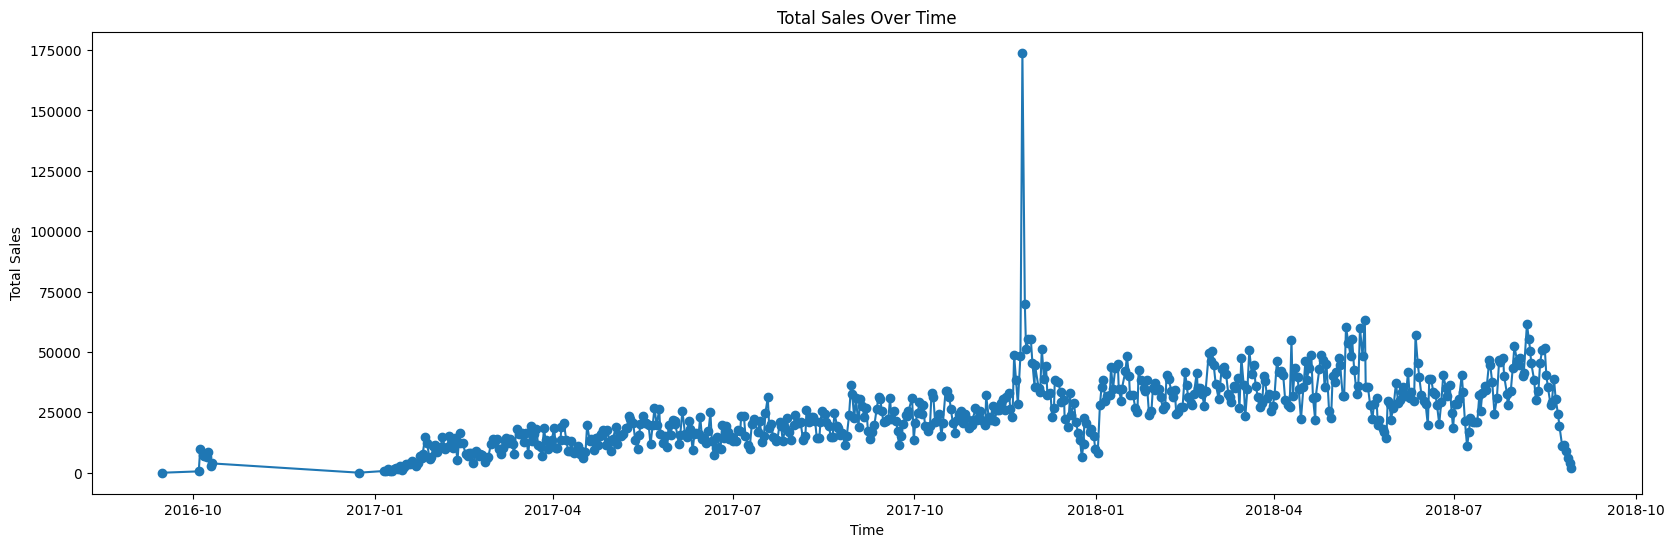

In [ ]:
conn = sqlite3.connect('debi.db')

query = '''
SELECT order_purchase_timestamp, SUM(payment_value) as total_sales
FROM orders
JOIN order_payments ON orders.order_id = order_payments.order_id
GROUP BY strftime('%Y-%m-%d', order_purchase_timestamp)
ORDER BY order_purchase_timestamp;
'''

df_sales_over_time = pd.read_sql_query(query, conn)
df_sales_over_time['order_purchase_timestamp'] = pd.to_datetime(df_sales_over_time['order_purchase_timestamp'])
plt.figure(figsize=(20, 6))
plt.plot(df_sales_over_time['order_purchase_timestamp'], df_sales_over_time['total_sales'], marker='o', linestyle='-')
plt.title('Total Sales Over Time')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.show()

conn.close()

## Example 2: Product Categories Distribution

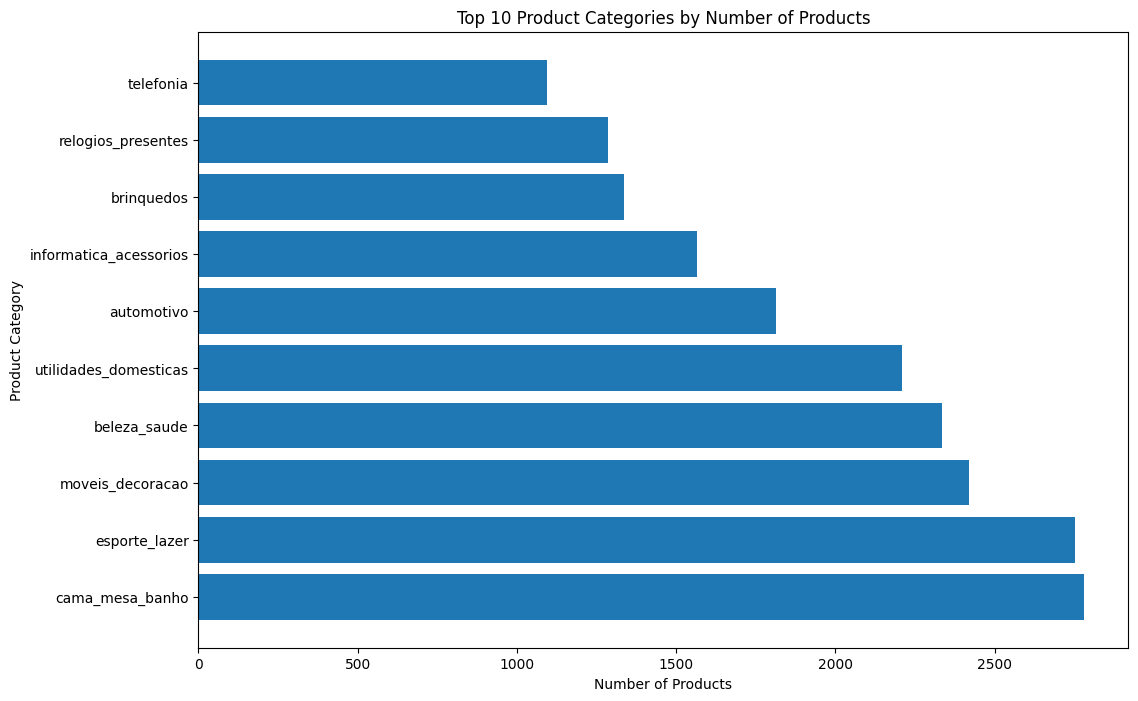

In [ ]:
conn = sqlite3.connect('debi.db')

query = '''
SELECT product_category_name, COUNT(product_id) as product_count
FROM products
GROUP BY product_category_name
ORDER BY product_count DESC
LIMIT 10;
'''

df_product_distribution = pd.read_sql_query(query, conn)
plt.figure(figsize=(12, 8))
plt.barh(df_product_distribution['product_category_name'], df_product_distribution['product_count'])
plt.title('Top 10 Product Categories by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()

conn.close()

#Distribution of Individual Review Scores

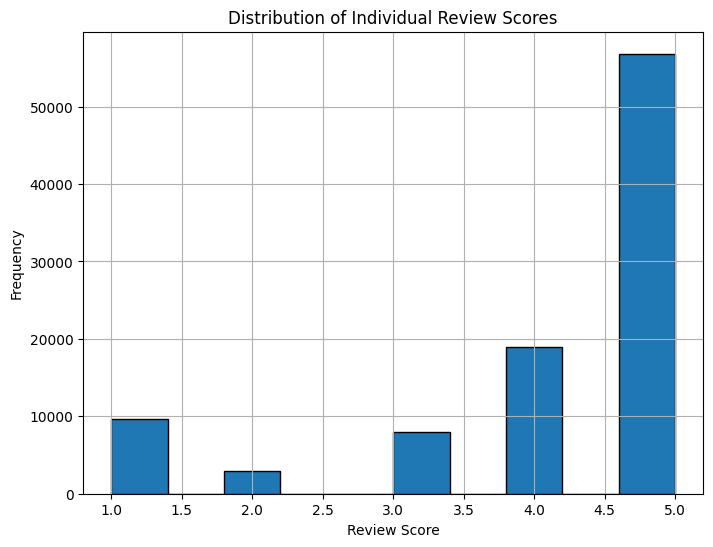

In [ ]:
import sqlite3
import matplotlib.pyplot as plt

# Connect to the SQLite database
conn = sqlite3.connect("debi.db")

# Define the SQL query to retrieve individual review scores
query = """
SELECT rv.review_score
FROM reviews rv;
"""

# Execute the query and fetch results
cursor = conn.execute(query)
review_scores = [row[0] for row in cursor]

# Close the connection
conn.close()

# Create a histogram of review scores
plt.figure(figsize=(8, 6))
plt.hist(reviews_df['review_scores'], bins=10, edgecolor='black')
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.title("Distribution of Individual Review Scores")
plt.grid(True)

plt.show()

# EDA

## Load the Data:


In [ ]:
# Connect to SQLite database
conn = sqlite3.connect('debi.db')

# Load data into DataFrames
customers_df = pd.read_sql_query("SELECT * FROM customers", conn)
product_category_df = pd.read_sql_query("SELECT * FROM product_category", conn)
products_df = pd.read_sql_query("SELECT * FROM products", conn)
orders_df = pd.read_sql_query("SELECT * FROM orders", conn)
sellers_df = pd.read_sql_query("SELECT * FROM sellers", conn)
order_payments_df = pd.read_sql_query("SELECT * FROM order_payments", conn)
order_items_df = pd.read_sql_query("SELECT * FROM order_items", conn)
reviews_df = pd.read_sql_query("SELECT * FROM reviews", conn)

# Close the connection
conn.close()

## Explore the Data:

In [ ]:
order_payments_df.replace('NA', np.nan, inplace=True)

       customer_zip_code
count       96478.000000
mean        35198.185358
std         29839.705392
min          1003.000000
25%         11355.000000
50%         24435.000000
75%         59056.000000
max         99980.000000
                              product_id product_category_name  \
count                              31111                 31111   
unique                             31111                    74   
top     00066f42aeeb9f3007548bb9d3f33c38       cama_mesa_banho   
freq                                   1                  2781   

        product_name_length product_description_length  product_photos_qty  \
count                 31111                      31111               31111   
unique                   65                       2934                  20   
top                      60                         NA                   1   
freq                   2075                        558               15481   

        product_weight_g  product_length_cm  product_

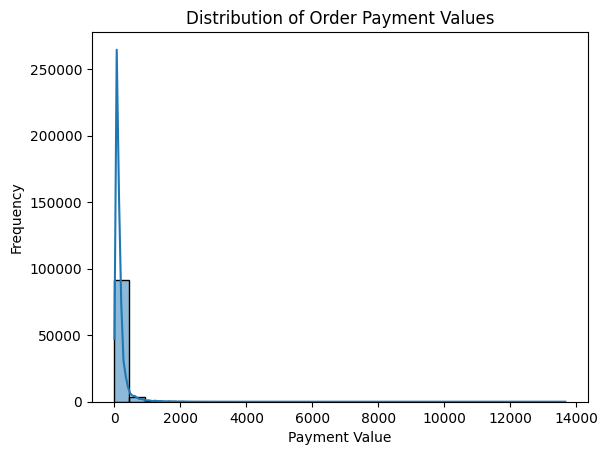

In [ ]:
# Display basic statistics
print(customers_df.describe())
print(products_df.describe())

# Histogram of order payment values
sns.histplot(order_payments_df['payment_value'], bins=30, kde=True)
plt.title('Distribution of Order Payment Values')
plt.xlabel('Payment Value')
plt.ylabel('Frequency')
plt.show()

## Analyze Relationships:

<ipython-input-15-fc3589e8d0ac>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  order_items_corr = order_items_df.corr()


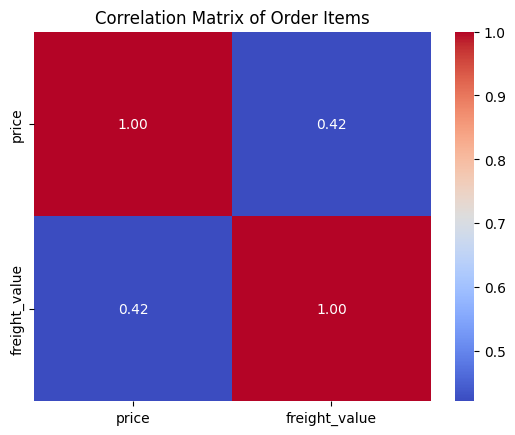

              payment_value
payment_type               
boleto           144.334979
credit_card      163.902094
debit_card       140.337455
voucher           77.233387


In [ ]:
# Correlation matrix of order items
order_items_corr = order_items_df.corr()
sns.heatmap(order_items_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Order Items')
plt.show()

# Pivot table to analyze average payment value by payment type
payment_type_pivot = order_payments_df.pivot_table(index='payment_type', values='payment_value', aggfunc='mean')
print(payment_type_pivot)

## Identify Patterns and Trends:

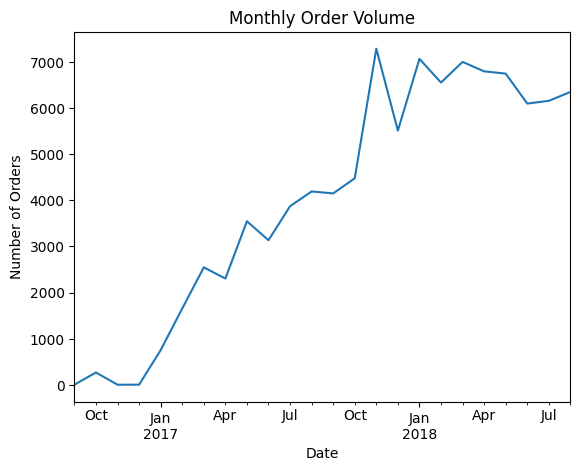

In [ ]:
# Time series analysis of order purchase timestamps
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df.set_index('order_purchase_timestamp', inplace=True)
orders_df.resample('M').size().plot(legend=False)
plt.title('Monthly Order Volume')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.show()

## Customer Analysis:

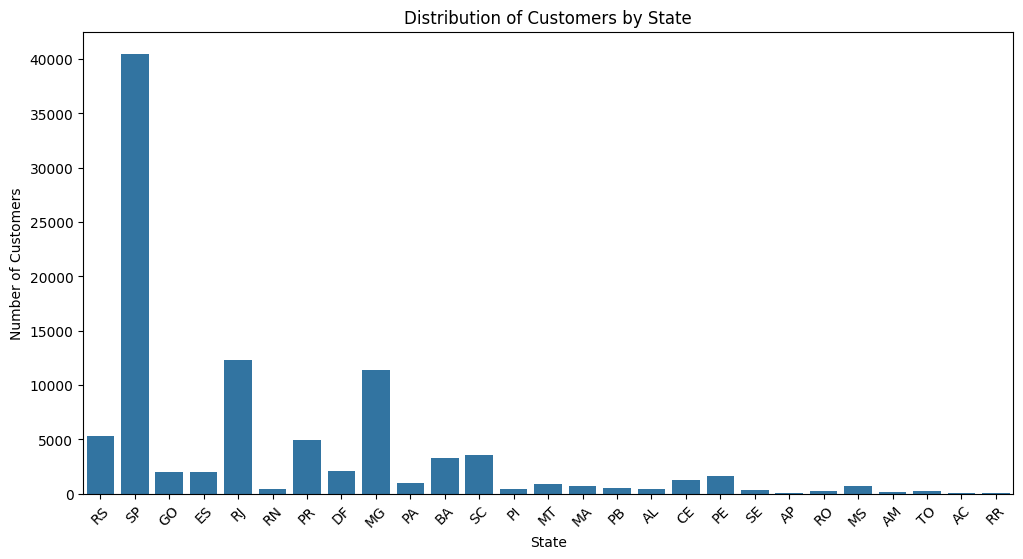

In [ ]:
#Customer demographic analysis
plt.figure(figsize=(12, 6))
sns.countplot(x='customer_state', data=customers_df)
plt.title('Distribution of Customers by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

## Seller Analysis:

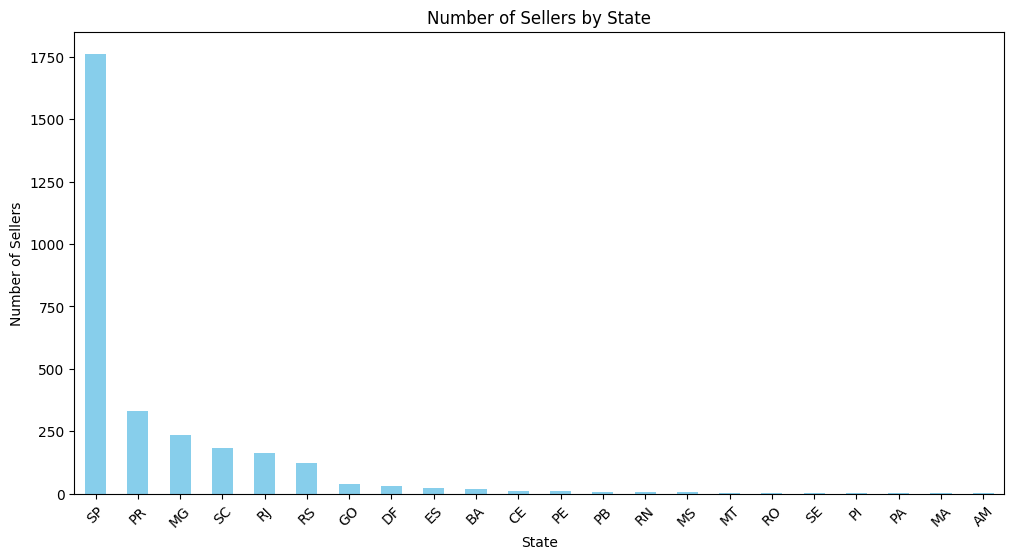

In [ ]:
# Seller performance analysis
seller_performance = sellers_df.groupby('seller_state').size().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
seller_performance.plot(kind='bar', color='skyblue')
plt.title('Number of Sellers by State')
plt.xlabel('State')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=45)
plt.show()

## Review Analysis:

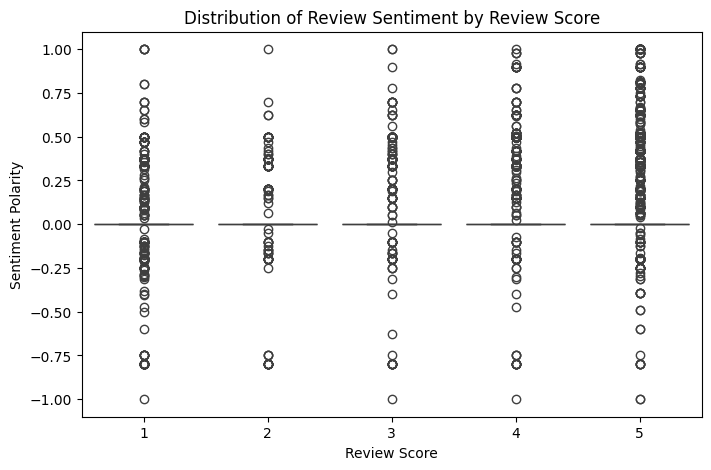

In [ ]:
# Calculate sentiment polarity of review comments
reviews_df['sentiment'] = reviews_df['review_comment_message'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
plt.figure(figsize=(8, 5))
sns.boxplot(x='review_score', y='sentiment', data=reviews_df)
plt.title('Distribution of Review Sentiment by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Sentiment Polarity')
plt.show()

## Derive Insights:

- Monthly order volume has been steadily increasing over time, indicating a growing customer base.
- The correlation between price and freight value in order items suggests that payment type significantly influences transaction values, reflecting customers' economic preferences, perceptions of security and convenience, and potential strategies for merchants to tailor marketing and pricing to optimize revenue generation through targeted customer segmentation.
- The customer demographic analysis highlights regional distribution patterns, providing insights into market potential, regional preferences, and logistical considerations for businesses seeking to optimize their market strategies and cater effectively to their diverse customer base.
- The seller performance analysis highlights state-wise variations in the number of sellers, indicating potential regional disparities in market competitiveness and business opportunities.
- The review sentiment analysis illustrates that there is a correlation between review score and sentiment polarity, indicating that higher review scores tend to be associated with more positive sentiment expressed in customer reviews.

# **Assignment Requirements:**

## 1) Product Performance Analysis:
- Identify the top 10 best-selling products.
- Visualization: Generate a bar chart showing the top 10 products and their sales.

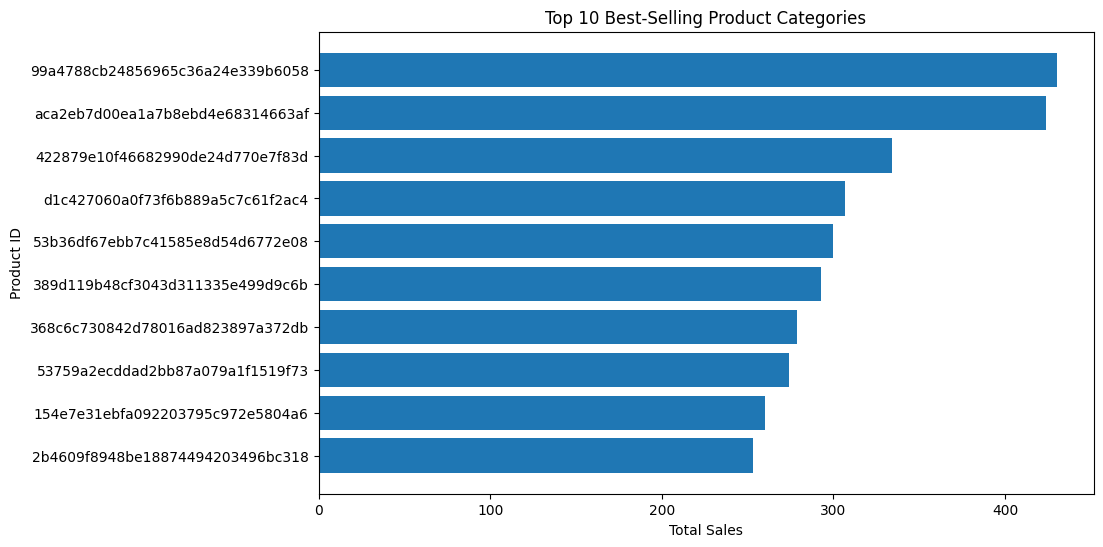

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')  # Replace 'your_database.db' with your database name

# Create a cursor object to execute SQL queries
cursor = conn.cursor()

# Execute a query to calculate total sales for each product category and select the top 10 categories
cursor.execute("""
    SELECT p.product_id as product_id ,
    COUNT(oi.product_id) as no_items_sold
    FROM products p
    LEFT JOIN order_items oi
    ON p.product_id = oi.product_id
    GROUP BY p.product_id
    ORDER BY no_items_sold DESC
    LIMIT 10;
""")

# Fetch all rows
rows = cursor.fetchall()

# Extract product category names and total sales from the result
categories = [row[0] for row in rows]
total_sales = [row[1] for row in rows]

# Generate bar chart
plt.figure(figsize=(10, 6))
plt.barh(categories, total_sales)
plt.xlabel('Total Sales')
plt.ylabel('Product ID')
plt.title('Top 10 Best-Selling Product Categories')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest sales at the top
plt.show()

# Close the cursor and connection
cursor.close()
conn.close()


## 2) Order Status Analysis:

- Analyze the distribution of order statuses (e.g., delivered, shipped, canceled).
- Visualization: Create a pie chart showing the proportion of each order status.

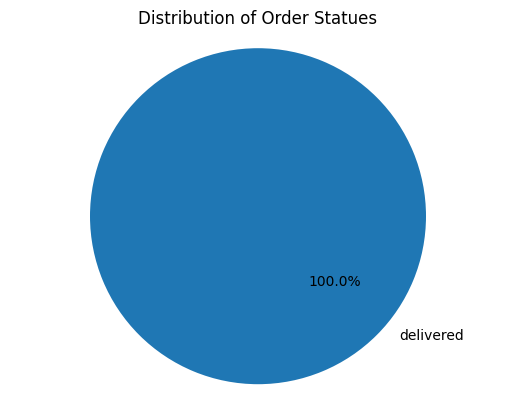

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Define the SQL query to retrieve the distribution of order statuses
query = '''
SELECT order_status, COUNT(*) as order_count
FROM orders
GROUP BY order_status;
'''

# Execute the query and read the results into a DataFrame
df_order_status = pd.read_sql_query(query, conn)

# Plot the pie chart
plt.pie(df_order_status['order_count'], labels=df_order_status['order_status'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Order Statues')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Close the database connection
conn.close()


## 3) Customer Segmentation:

- Segment customers based on their purchasing patterns. Are there distinct groups that emerge?
- Visualization: Create a scatter plot visualizing the segments.
- Tip: Use clustering techniques like K-Means on features such as purchase frequency, average spend, and product categories bought.

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Define the SQL query to retrieve necessary customer information
query = '''
SELECT c.customer_id,
       c.customer_city,
       c.customer_state,
       COUNT(*) AS purchase_frequency,
       AVG(op.payment_value) AS average_spend,
       GROUP_CONCAT(DISTINCT p.product_category_name || ', ') AS product_category_name  -- Concatenate with comma and space
FROM customers c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN order_payments op ON o.order_id = op.order_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id, c.customer_city, c.customer_state;
'''

In [ ]:
# Execute the query and read the results into a DataFrame
df_customer_info = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [ ]:
# Drop any rows with missing values
df_customer_info.dropna(inplace=True)

# Define columns for categorical and numeric features
categorical_columns = ['customer_city', 'customer_state', 'product_category_name']
numeric_columns = ['purchase_frequency', 'average_spend']

# Define preprocessing steps for categorical and numeric features
categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numeric_transformer, numeric_columns)
    ])

# Define the K-Means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)

# Create a pipeline with preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans)
])

# Fit the pipeline to the data
pipeline.fit(df_customer_info)

# Get cluster labels
clusters = pipeline.named_steps['kmeans'].labels_

# Add cluster labels to the DataFrame
df_customer_info['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


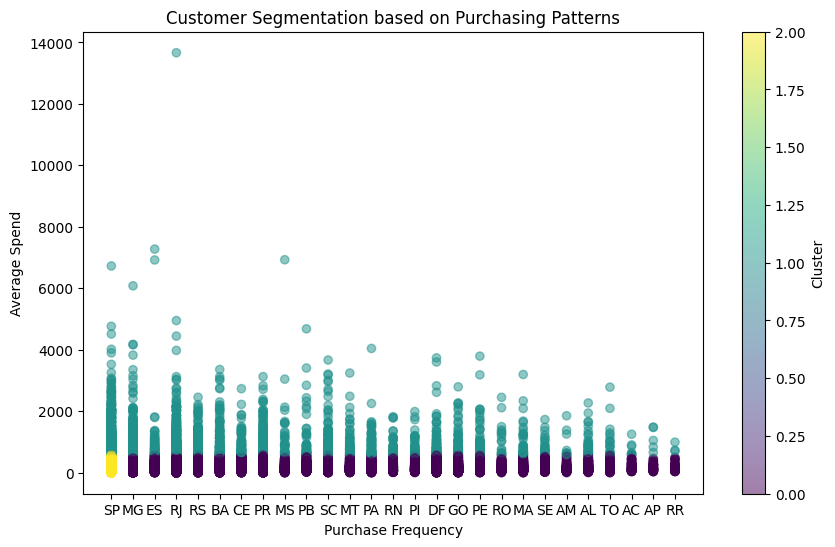

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_customer_info['customer_state'], df_customer_info['average_spend'], c=df_customer_info['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Spend')
plt.title('Customer Segmentation based on Purchasing Patterns')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Define the SQL query to retrieve necessary customer information
query = '''
SELECT c.customer_id,
       c.customer_city,
       c.customer_state,
       o.order_purchase_timestamp,
       op.payment_type,
       oi.seller_Id,
       r.review_score,
       COUNT(o.order_id) AS purchase_frequency,
       AVG(op.payment_value) AS average_spend,
       COUNT(DISTINCT p.product_category_name) AS num_product_categories
FROM customers c
LEFT JOIN orders o ON c.customer_id = o.customer_id
LEFT JOIN reviews r ON r.order_id = o.order_id
LEFT JOIN order_payments op ON o.order_id = op.order_id
LEFT JOIN order_items oi ON o.order_id = oi.order_id
LEFT JOIN products p ON oi.product_id = p.product_id
GROUP BY c.customer_id;
'''

In [ ]:
# Execute the query and read the results into a DataFrame
df_customer_info = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

In [ ]:
# Drop any rows with missing values
df_customer_info.dropna(inplace=True)

# Define columns for categorical and numeric features
categorical_columns = ['customer_city', 'customer_state', 'payment_type']
numeric_columns = ['review_score', 'purchase_frequency', 'average_spend', 'num_product_categories']

# Define preprocessing steps for categorical and numeric features
categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Combine preprocessing steps for all features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numeric_transformer, numeric_columns)
    ])

# Define the K-Means clustering model
kmeans = KMeans(n_clusters=3, random_state=42)

# Create a pipeline with preprocessing and clustering
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans)
])

# Fit the pipeline to the data
pipeline.fit(df_customer_info)

# Get cluster labels
clusters = pipeline.named_steps['kmeans'].labels_

# Add cluster labels to the DataFrame
df_customer_info['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


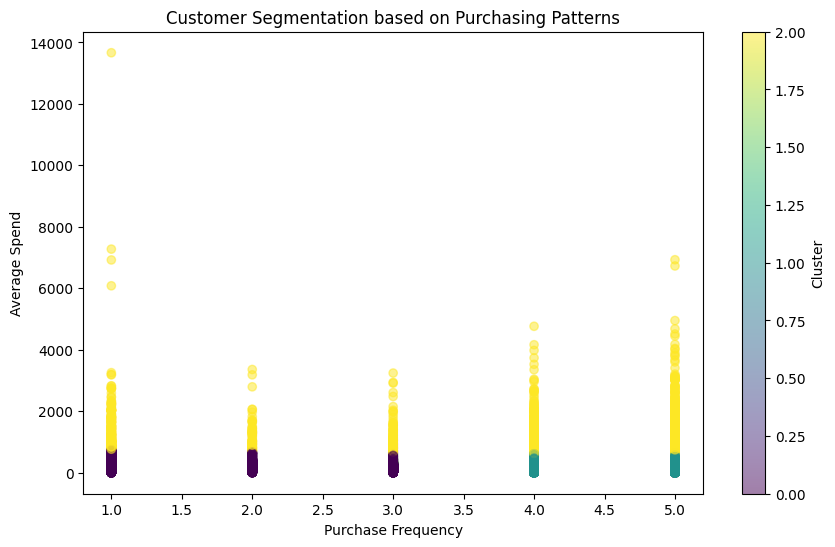

In [ ]:
# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_customer_info['review_score'], df_customer_info['average_spend'], c=df_customer_info['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Spend')
plt.title('Customer Segmentation based on Purchasing Patterns')
plt.colorbar(label='Cluster')
plt.show()

## 4) Review Score Impact:

- Investigate the relationship between review scores and product sales.
- Visualization: Create a line plot or scatter plot showing review scores against sales.

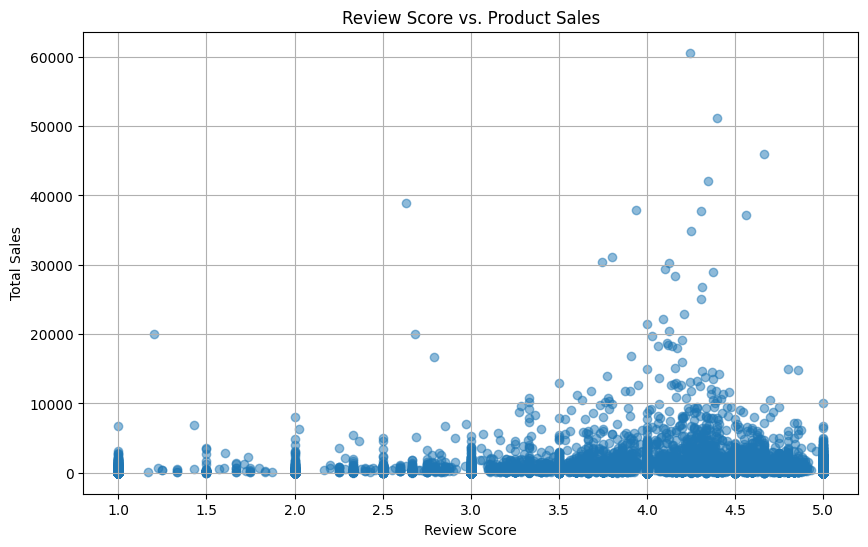

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Merge order items with reviews on order_id to associate review scores with product sales
query = '''
SELECT order_items.product_id, AVG(reviews.review_score) AS review_score, SUM(order_items.price) AS total_sales
FROM order_items
LEFT JOIN (
    SELECT order_id, review_score
    FROM reviews
) AS reviews ON order_items.order_id = reviews.order_id
GROUP BY order_items.product_id;
'''

# Execute the query and read the results into a DataFrame
product_sales_review = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(product_sales_review['review_score'], product_sales_review['total_sales'], alpha=0.5)
plt.title('Review Score vs. Product Sales')
plt.xlabel('Review Score')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

## 5) Geographic Sales Distribution:

- Analyze sales distribution across different states or cities.
- Visualization: Create a heatmap or geographical plot showing sales distribution.

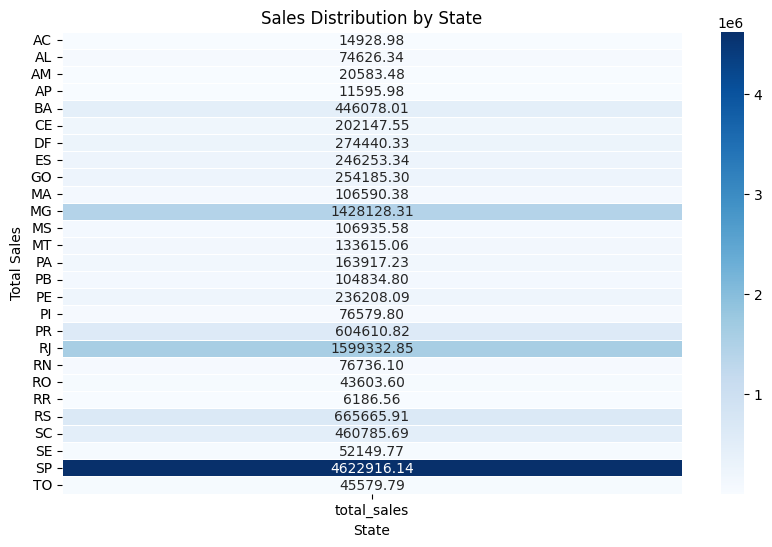

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Define the SQL query to retrieve sales distribution by state
query = '''
SELECT customers.customer_state, SUM(order_items.price) AS total_sales
FROM orders
JOIN customers ON orders.customer_id = customers.customer_id
JOIN order_items ON orders.order_id = order_items.order_id
GROUP BY customers.customer_state;
'''

# Execute the query and read the results into a DataFrame
df_sales_distribution = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Create a pivot table for better visualization
pivot_sales = df_sales_distribution.pivot_table(index='customer_state', values='total_sales', aggfunc='sum')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sales, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)
plt.title('Sales Distribution by State')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.show()

## 6) Time Series Analysis:

- Explore how sales have changed over time on a monthly basis.
- Visualization: Create a time series plot showing trends in monthly sales.

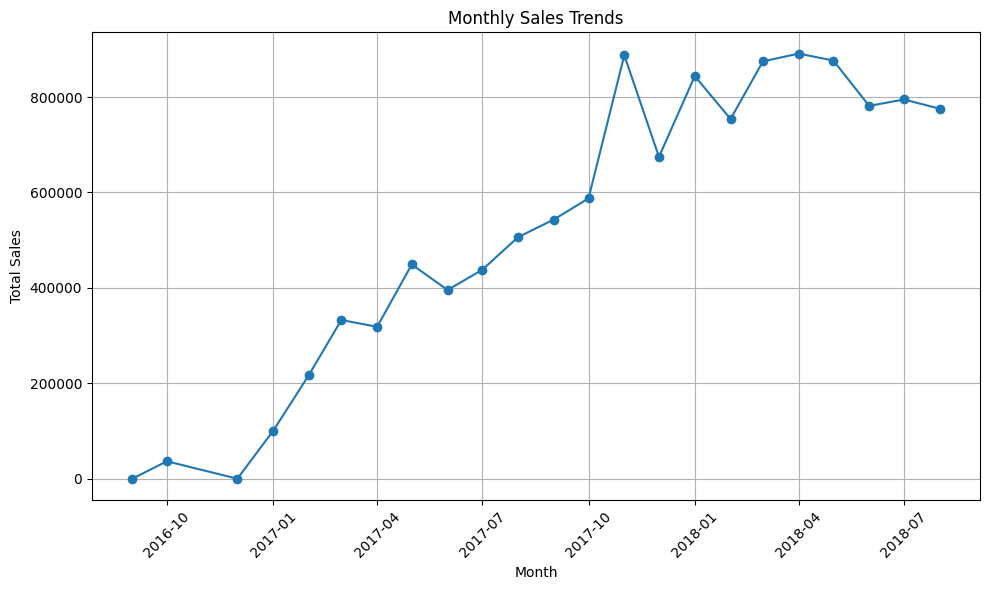

In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect('debi.db')

# Define the SQL query to retrieve monthly sales data
query = '''
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month_year,
       SUM(order_items.price) AS total_sales
FROM orders
JOIN order_items ON orders.order_id = order_items.order_id
GROUP BY month_year;
'''

# Execute the query and read the results into a DataFrame
df_monthly_sales = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Convert month_year to datetime format for proper sorting
df_monthly_sales['month_year'] = pd.to_datetime(df_monthly_sales['month_year'])

# Plot the time series of monthly sales
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_sales['month_year'], df_monthly_sales['total_sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# **Delivery:**
- Jupyter notebook containing code for all above requirements.
- Power Point presentation (10 slides max) showing the following:
-- Showcase the tools and libraries used (e.g., Scikit-learn, Pandas) and visualizations produced during the analysis.
-- Summarize key findings and conclusions drawn from the data analysis, particularly focusing on customer segmentation and product performance.




# **Data Analysis Assignment Presentation Example Outline**

## Slide 1: Title Slide

## Slide 2: ML Tools and Libraries Used, for example:
- Pandas for data manipulation and analysis
- Scikit-learn for machine learning tasks
- Matplotlib and Seaborn for data visualization
- Machine Learning algorithms used:
-- Tsne for visualization
-- K-means
-- PCA for dimensionality reduction
-- etc...

## Slides 3: Dataset Overview
- Describe the source and structure of the e-commerce dataset.
- Include a small visualization, like a dataset schema or a few rows of the dataset to give a concrete idea.
- Mention the key variables that will be analyzed.

## Slide 4: Initial EDA (Exploratory Data Analysis) Findings
- Present a couple of initial findings from exploratory data analysis.
- Use simple visualizations like histograms for the distribution of key variables or a heatmap for correlations.
- Briefly mention any surprising insights or patterns discovered.

### Slide 5: Methodology and Segmentation
- Description of the clustering method used (e.g., K-Means)
- Criteria for segmentation (e.g., purchase frequency, average spend)

### Slide 6: Segmentation Results
- Visualizations illustrating customer segments
- Characteristics of each segment

## Slides 7-8: Product Performance Analysis
### Slide 7: Analysis Criteria
- Metrics used to evaluate product performance (e.g., sales volume, return rates)

### Slide 8: Performance Insights
- Graphs showing sales trends and product categorization
- Discussion on top-performing and underperforming products

## Slide 9: Key Findings and Conclusions
- Summarize crucial insights from the customer segmentation and product performance analysis
- Implications for marketing strategies and product management

## Slide 10: References and Data Sources
- List of data sources, documentation, and any external references used